## Modelo binario de clasificación 

En esta libreta de jupyter vamos a realizar el desarrollo de un modelo binario predictivo para el problema de minsait

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

from ipywidgets import interact 

#Modelo
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
list_class_order = ['RESIDENTIAL', 'PUBLIC', 'RETAIL', 'OFFICE', 'INDUSTRIAL', 'AGRICULTURE', 'OTHER']

In [3]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [4]:
def show_results(y, y_pred):
    sns.heatmap(confusion_matrix(y, y_pred), square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    print("Resultados")
    print('Accuracy: {}'.format(round(accuracy_score(y, y_pred), 3)))

In [5]:
df_minsait = pd.read_csv('data/Modelar_UH2020.txt', sep="|", index_col='ID', encoding='utf-8')
print("Tamaño del conjunto de datos:  %d" % df_minsait.shape[0])
print("Número de variables: %d" % df_minsait.shape[1])
if df_minsait.index.is_unique:
    print('El índice es único.')
else:
    print('Los índices están duplicados.')
df_minsait.head()

Tamaño del conjunto de datos:  103230
Número de variables: 55
El índice es único.


,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,...,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE
ID,,,,,,,,,,,,,,,,,,,,,
35984B9C3E7CD9A1,2207357872,165920300,0.000000,443.001300,616.001697,746.998401,872.996472,1009.000946,1159.002319,1342.002466,...,10951.926645,144.426900,0.557237,0.067249,0.057372,0.853127,2002,0.0,2,RESIDENTIAL
F9D04BF6D037F8FB,2189757160,165463267,0.000059,443.899011,627.999060,770.001611,904.999988,1032.998474,1165.001636,1316.000110,...,7048.367637,38.342550,0.709884,0.125156,0.147929,1.181953,1949,1.0,8,RESIDENTIAL
B89D5711AFF8C423,2240147335,165690752,0.000000,353.502274,523.003601,644.001831,760.997131,876.999634,1006.997498,1168.995544,...,7013.073271,108.794384,0.517702,0.058268,0.081666,1.401552,1986,1.0,5,RESIDENTIAL
1C3478AC1522E7E4,2227146459,165934099,0.000000,268.000613,376.999609,478.003784,575.001233,683.997742,809.005994,955.002960,...,6216.880538,155.224455,0.450871,0.053591,0.054201,1.011382,1999,1.0,2,RESIDENTIAL
4D12AA5009064345,2212350459,165681791,0.000000,318.997910,492.003845,632.999634,757.002197,882.999908,1019.008911,1175.993103,...,7092.767616,1789.873366,0.458819,0.012858,0.019936,1.550478,1966,8.0,6,RESIDENTIAL


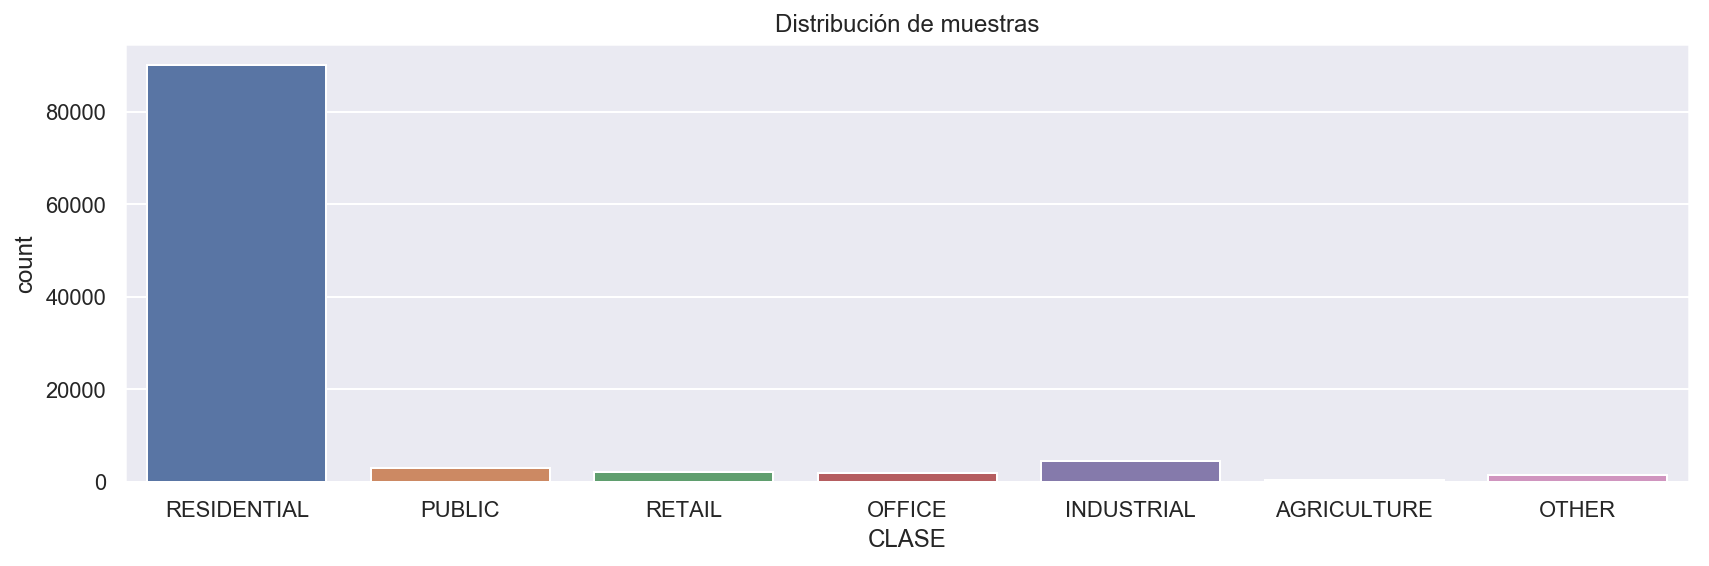

In [6]:
plt.figure(figsize=(12,4))
sns.countplot(x='CLASE', data=df_minsait, order=list_class_order)
plt.title('Distribución de muestras')
plt.tight_layout()
plt.show()

In [7]:
dis_df_columns = df_minsait.select_dtypes(exclude=np.number).columns.tolist()
dis_df_columns.remove('CLASE') #Eliminamos la variable clase
number_df_columns = df_minsait.select_dtypes(include=np.number).columns.tolist()

print('Discretas: ',dis_df_columns)
print('\nNuméricas: ',number_df_columns)

Discretas:  ['CADASTRALQUALITYID']

Numéricas:  ['X', 'Y', 'Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3', 'Q_R_4_0_4', 'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8', 'Q_R_4_0_9', 'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2', 'Q_G_3_0_3', 'Q_G_3_0_4', 'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7', 'Q_G_3_0_8', 'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1', 'Q_B_2_0_2', 'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6', 'Q_B_2_0_7', 'Q_B_2_0_8', 'Q_B_2_0_9', 'Q_B_2_1_0', 'Q_NIR_8_0_0', 'Q_NIR_8_0_1', 'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4', 'Q_NIR_8_0_5', 'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8', 'Q_NIR_8_0_9', 'Q_NIR_8_1_0', 'AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4', 'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR']


In [8]:
def preprocess_function(functions, df):
    [f(df) for f in functions]

process_dataframe = []

In [9]:
def process_cadastral_quality(df):
    dic = {'A': 11, 'B': 10, 'C': 9, '1': 8, '2': 7, '3': 6, '4': 5, '5': 4, '6': 3, '7': 3, '8': 1, '9': 0}
    df['CADASTRALQUALITYID'] = df['CADASTRALQUALITYID'].apply(lambda x: dic[x] if x not in [np.NaN] else -1)
    return df

process_dataframe.append(process_cadastral_quality)

In [10]:
dis_df_columns.remove('CADASTRALQUALITYID')
number_df_columns.append('CADASTRALQUALITYID')

In [11]:
def process_max_building_floor(df):
    df['MAXBUILDINGFLOOR'].fillna(-1, inplace=True)
    return df

process_dataframe.append(process_max_building_floor)

In [12]:
def normalize_colors(df):
    scaler = MinMaxScaler()
    df[df.columns[2:-9]] = scaler.fit_transform(df[df.columns[2:-9]])
    
process_dataframe.append(normalize_colors)

In [13]:
def pca_colors(df):
    df_pca = pd.DataFrame(df.index).set_index('ID')
    
    pca = PCA(n_components=1)
    pca.fit(df[df.columns[2:13]])
    df_pca = df_pca.merge(pd.DataFrame(index=df.index, data=pca.transform(df[df.columns[2:13]]), columns=['PCA_RED']), on='ID')
    
    pca.fit(df[df.columns[13:24]])
    df_pca = df_pca.merge(pd.DataFrame(index=df.index, data=pca.transform(df[df.columns[13:24]]), columns=['PCA_GREEN']), on='ID')
    
    pca.fit(df[df.columns[24:35]])
    df_pca = df_pca.merge(pd.DataFrame(index=df.index, data=pca.transform(df[df.columns[24:35]]), columns=['PCA_BLUE']), on='ID')
    
    pca.fit(df[df.columns[35:46]])
    df_pca = df_pca.merge(pd.DataFrame(index=df.index, data=pca.transform(df[df.columns[35:46]]), columns=['PCA_NIR']), on='ID')
    
    df.drop(columns=df.columns[2:46], axis=1, inplace=True)
    clase = df.CLASE
    df.drop(columns='CLASE', axis=1, inplace=True)
    
    #Para insertar lso nuevos valores y mantener la estructura de tener la clase en ultimo lugar
    df = df.merge(df_pca, on='ID')
    df['CLASE'] = clase
    return df

In [14]:
#Ahora aplicamos todo el preprocesamiento al dataframe
preprocess_function(process_dataframe, df_minsait)
df_minsait = pca_colors(df_minsait)

In [15]:
df_minsait.describe()

,X,Y,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,PCA_RED,PCA_GREEN,PCA_BLUE,PCA_NIR
count,1.032300e+05,1.032300e+05,103230.000000,103230.000000,103230.000000,103230.000000,103230.000000,103230.000000,103230.000000,103230.000000,1.032300e+05,1.032300e+05,1.032300e+05,1.032300e+05
mean,2.208858e+09,1.655955e+08,441.123610,0.563343,0.062482,0.061855,1.074327,1972.552436,3.765785,3.987368,-6.284750e-17,-2.346090e-17,-1.362212e-16,-5.366401e-17
std,2.751723e+07,2.040199e+05,1869.705189,0.174141,0.042849,0.042295,0.541156,22.335987,2.945358,1.452818,3.730496e-01,3.487598e-01,3.669081e-01,4.140868e-01
min,2.120751e+09,1.650957e+08,0.038770,0.000626,0.000679,0.000770,0.015157,1820.000000,-1.000000,-1.000000,-1.353038e+00,-1.085228e+00,-1.298705e+00,-7.191408e-01
25%,2.194235e+09,1.654515e+08,97.477454,0.455183,0.038255,0.038153,0.801352,1960.000000,1.000000,3.000000,-1.599365e-01,-1.793102e-01,-2.442972e-01,-2.807727e-01
50%,2.205985e+09,1.655907e+08,171.554907,0.536336,0.055802,0.055036,0.997175,1972.000000,4.000000,4.000000,6.207699e-02,-1.992082e-02,-9.491601e-02,5.818183e-03
75%,2.224105e+09,1.657138e+08,343.563671,0.674723,0.078477,0.078064,1.223456,1989.000000,5.000000,5.000000,2.087206e-01,1.762840e-01,1.798099e-01,2.154578e-01
max,2.287300e+09,1.665046e+08,238058.952253,1.000000,1.785714,2.631579,68.812431,2017.000000,25.000000,11.000000,1.450787e+00,1.669345e+00,1.452702e+00,2.164936e+00


---

Ahora vamos a convertir un problema multietiqueta en uno binario, utlizando para esta discriminación la clase mayoritaría **Residencial** y el resto de etiquetas como **No Residencial**.

In [16]:
df_minsait['SUBCLASE'] = (df_minsait['CLASE'] == 'RESIDENTIAL').astype(int)

In [17]:
df_minsait[df_minsait.columns[-2:]].head()

,CLASE,SUBCLASE
ID,,
35984B9C3E7CD9A1,RESIDENTIAL,1
F9D04BF6D037F8FB,RESIDENTIAL,1
B89D5711AFF8C423,RESIDENTIAL,1
1C3478AC1522E7E4,RESIDENTIAL,1
4D12AA5009064345,RESIDENTIAL,1


In [18]:
#Necesitamos balancear las clases en la medida de lo posible sin eliminar la superioridad clara de la clase mayoritaría

#Obtenemos una decima parte de los datos de la clase residencial desordenados
df_minsait_reduce = df_minsait[df_minsait['CLASE']=='RESIDENTIAL'].sample(frac=0.2, random_state=10)

#Concatenamos los datos del resto de etiquetas
df_minsait_reduce = df_minsait_reduce.append(df_minsait[df_minsait['CLASE']!='RESIDENTIAL'])

display(df_minsait_reduce.shape)

display(df_minsait_reduce['CLASE'].value_counts())

(31092, 16)

RESIDENTIAL    18035
INDUSTRIAL      4490
PUBLIC          2976
RETAIL          2093
OFFICE          1828
OTHER           1332
AGRICULTURE      338
Name: CLASE, dtype: int64

In [19]:
print(f"Hay {np.round((len(df_minsait_reduce[df_minsait_reduce['SUBCLASE']==0]))/len(df_minsait_reduce), 3)} de la clase No Residencial")
print(f"Hay {np.round(1-(len(df_minsait_reduce[df_minsait_reduce['SUBCLASE']==0]))/len(df_minsait_reduce), 3)} de la clase Residencial")

Hay 0.42 de la clase No Residencial
Hay 0.58 de la clase Residencial


In [20]:
#Para nuestro primer modelo vamos a usar todas las variables
X = df_minsait_reduce[df_minsait_reduce.columns[:-2]].copy()
y = df_minsait_reduce['SUBCLASE'].copy()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [22]:
#Transformación que se le va a aplicar a las columnas numéricas
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                             ('scaler', StandardScaler())])

In [23]:
#Transformación que se le va a aplicar a las columnas categóricas
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                           ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# QUITAR LUEGO o ADAPTARLO

In [24]:
dis_df_columns = df_minsait.select_dtypes(exclude=np.number).columns.tolist()
dis_df_columns.remove('CLASE') #Eliminamos la variable clase
number_df_columns = df_minsait.select_dtypes(include=np.number).columns.tolist()
number_df_columns.remove('SUBCLASE') #Eliminamos la variable clase

In [25]:
#Transformador que se aplica a cada una de las columnas en función a lo declarado previamente
df_minsait_trans = ColumnTransformer(transformers=[('num', num_transformer, number_df_columns)])

In [29]:
import xgboost as xgb
rfc_p_model = xgb.XGBClassifier(random_state=10)

parameters = {
    'clas__max_depth': [10, 20, 30],
    'clas__scale_pos_weight': [1]
}

minsait_pipe_rfc_p = Pipeline(steps=[('prep', df_minsait_trans), ('clas', rfc_p_model)])

GSR_p = GridSearchCV(minsait_pipe_rfc_p, parameters, cv=5, n_jobs=-1, scoring='accuracy', refit=True, verbose=1)
GSR_p.fit(X_train, y_train)
    
print("Mejor score: ", GSR_p.best_score_)
print("Mejore configuración de parámetros: ", GSR_p.best_params_)

minsait_pipe_rfc_p = GSR_p.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   20.7s finished


Mejor score:  0.8510381827610438
Mejore configuración de parámetros:  {'clas__max_depth': 20, 'clas__scale_pos_weight': 1}


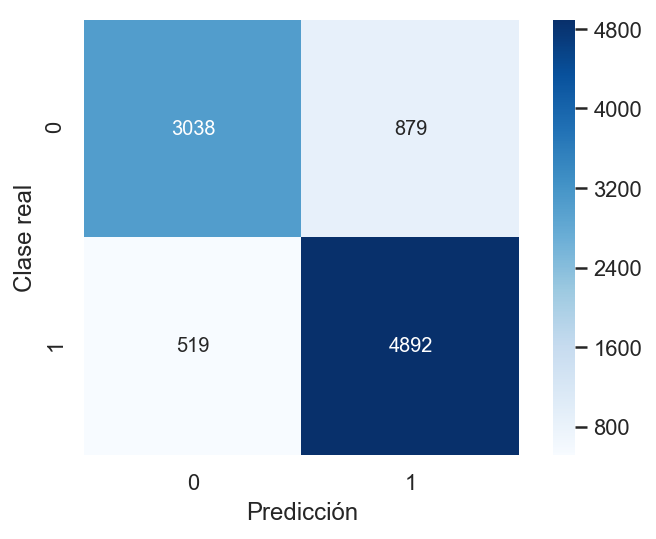

Resultados
Accuracy: 0.85


In [30]:
y_pred = minsait_pipe_rfc_p.predict(X_test)
show_results(y_test, y_pred)

In [33]:
list_ids_no_residential = X_test[y_pred==0].index.tolist()

In [34]:
df_no_resident = df_minsait[df_minsait.index.isin(list_ids_no_residential)]
df_no_resident.shape

(3557, 16)

In [35]:
df_resident = df_minsait[~df_minsait.index.isin(list_ids_no_residential)]
display(df_resident.shape)
y_resident = df_resident['CLASE']

(99673, 16)

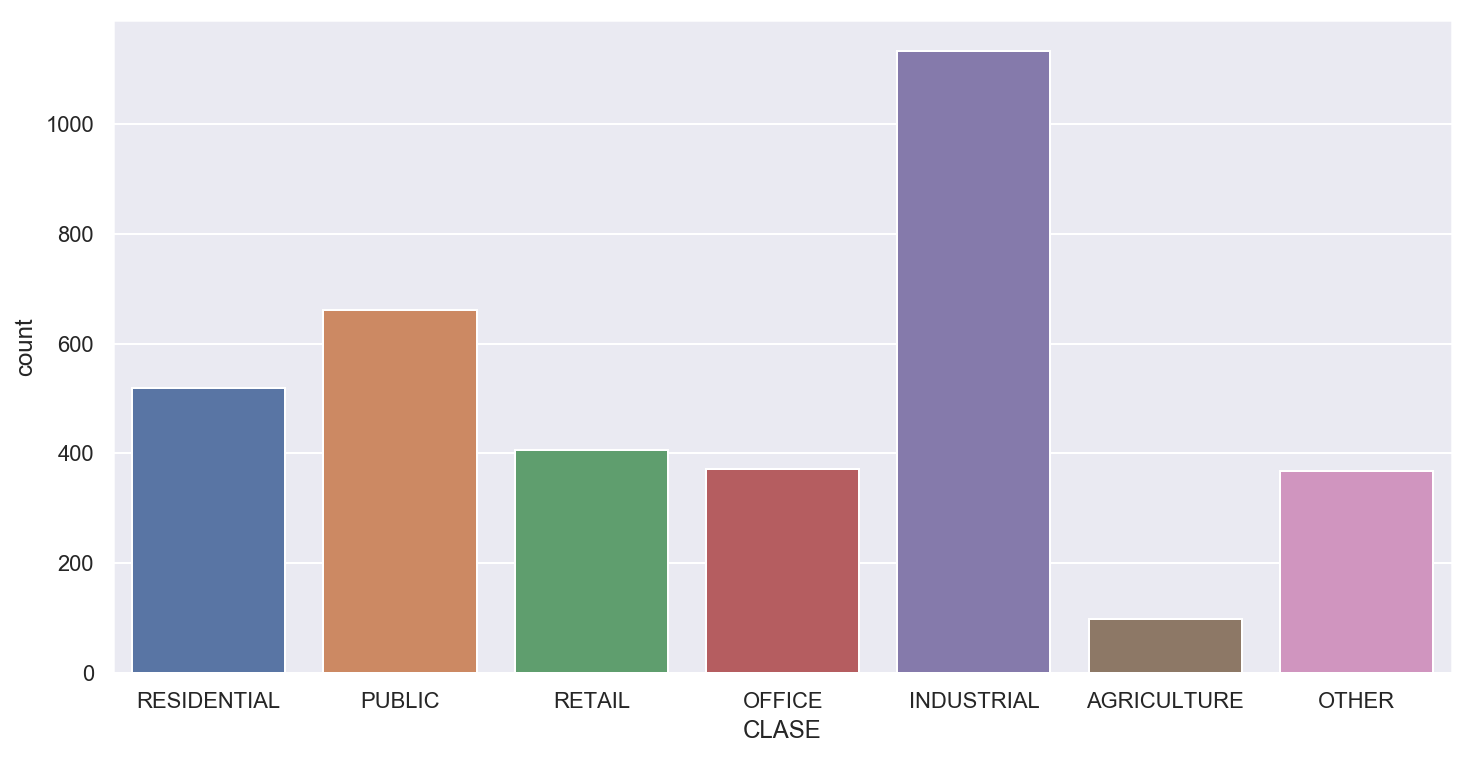

In [36]:
plt.figure(figsize=(12,6))
sns.countplot(df_no_resident.CLASE, order=list_class_order);

In [37]:
import pickle
pickle.dump(minsait_pipe_rfc_p, open('./models/binary2.pkl', 'wb'))

---

## Modelo multiclase balanceada

In [38]:
#Obtenemos una decima parte de los datos de la clase residencial desordenados
df_minsait_reduce_multi = df_minsait[df_minsait['CLASE']=='RESIDENTIAL'].sample(frac=0.02, random_state=10)

#Concatenamos los datos del resto de etiquetas
df_minsait_reduce_multi = df_minsait_reduce_multi.append(df_minsait[df_minsait['CLASE']!='RESIDENTIAL'])

display(df_minsait_reduce_multi.shape)

display(df_minsait_reduce_multi['CLASE'].value_counts())

(14860, 16)

INDUSTRIAL     4490
PUBLIC         2976
RETAIL         2093
OFFICE         1828
RESIDENTIAL    1803
OTHER          1332
AGRICULTURE     338
Name: CLASE, dtype: int64

Hay 0.121% de la clase RESIDENTIAL
Hay 0.302% de la clase INDUSTRIAL
Hay 0.2% de la clase PUBLIC
Hay 0.123% de la clase OFFICE
Hay 0.09% de la clase OTHER
Hay 0.141% de la clase RETAIL
Hay 0.023% de la clase AGRICULTURE


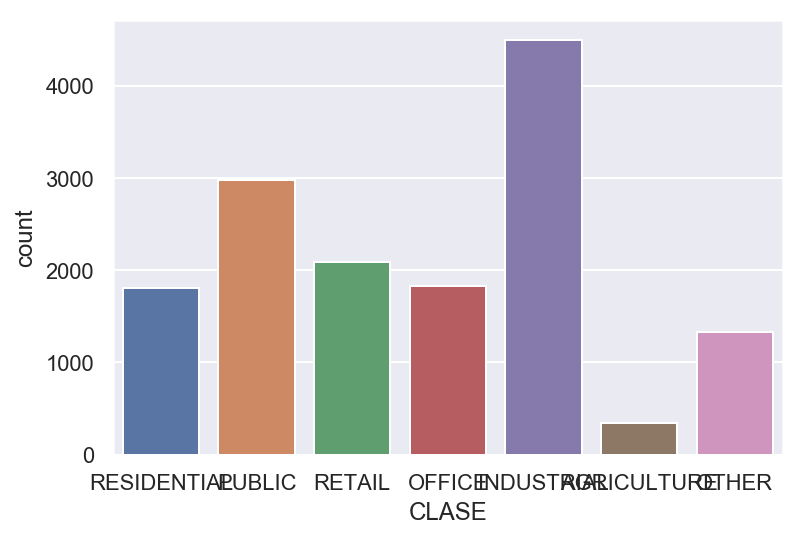

In [39]:
sns.countplot(df_minsait_reduce_multi['CLASE'], order=list_class_order);
for c in df_minsait_reduce_multi['CLASE'].unique():
    print(f"Hay {np.round((len(df_minsait_reduce_multi[df_minsait_reduce_multi['CLASE']==c]))/len(df_minsait_reduce_multi), 3)}% de la clase {c}")

In [40]:
#Para nuestro primer modelo vamos a usar todas las variables
X = df_minsait_reduce_multi[df_minsait_reduce_multi.columns[:-2]].copy()
y = df_minsait_reduce_multi['CLASE'].copy()

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [42]:
rfc_p_multi_model = RandomForestClassifier(random_state=10)

parameters = {}
parameters['clas__max_depth'] = [10, 20, 30] #Quitamos None para que no sobreajuste al conjunto de train y que no pueda hacer la profundidad que el modelo desee. 
                                               # Lo forzamos a ponerle profundidad, como máximo 30, aunque se podría establecer mayor profundidad pero he decidido que sea esa.
parameters['clas__n_estimators'] = [200, 350, 500]
parameters['clas__criterion'] = ['gini']
parameters['clas__class_weight'] = ['balanced']

minsait_pipe_rfc_multi_p = Pipeline(steps=[('prep', df_minsait_trans), ('clas', rfc_p_multi_model)])

GSR_p = GridSearchCV(minsait_pipe_rfc_multi_p, parameters, cv=5, n_jobs=-1, scoring='accuracy', refit=True, verbose=1)
GSR_p.fit(X_train, y_train)
    
print("Mejor score: ", GSR_p.best_score_)
print("Mejore configuración de parámetros: ", GSR_p.best_params_)

minsait_pipe_rfc_multi_p = GSR_p.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   29.6s finished


Mejor score:  0.5796004602077403
Mejore configuración de parámetros:  {'clas__class_weight': 'balanced', 'clas__criterion': 'gini', 'clas__max_depth': 20, 'clas__n_estimators': 500}


In [43]:
y_pred = minsait_pipe_rfc_multi_p.predict(X_test)

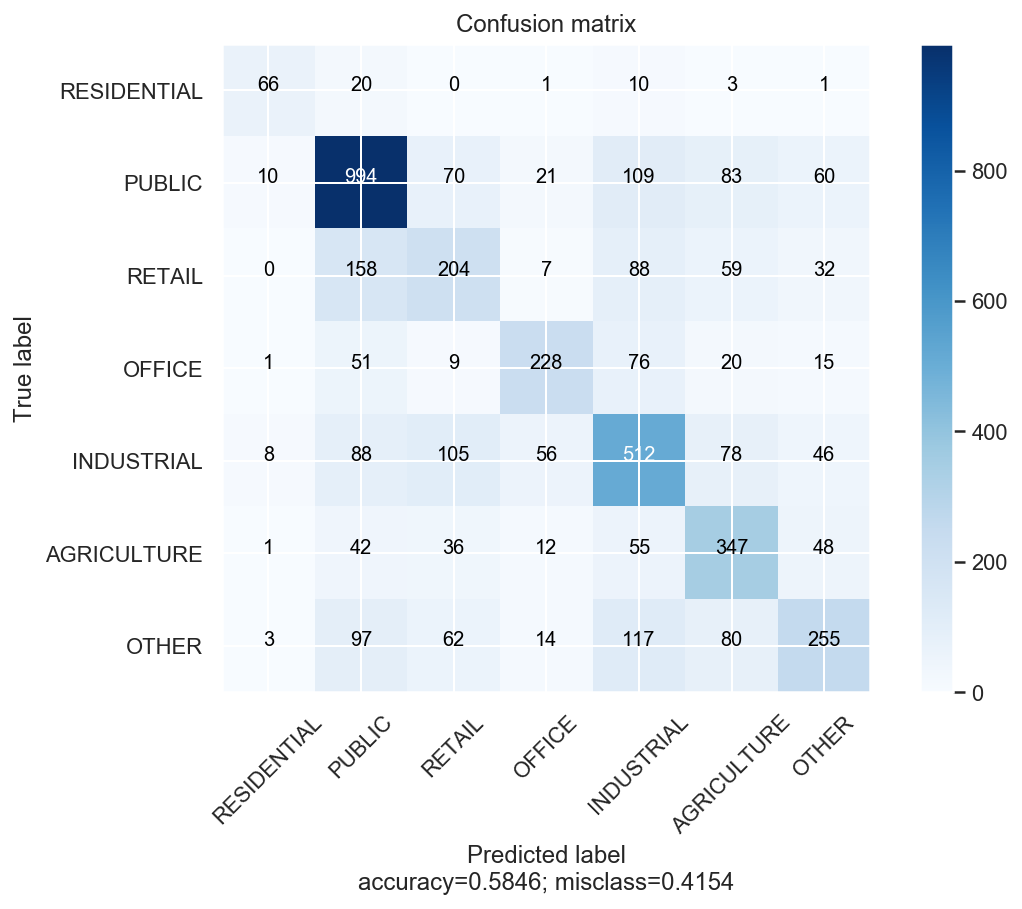

In [44]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), target_names= list_class_order, cmap=plt.cm.Blues, normalize=False)

In [45]:
import pickle
pickle.dump(minsait_pipe_rfc_multi_p, open('./models/multiclass2.pkl', 'wb'))

---

# Predicción con los dos modelos

In [46]:
df_no_resident.head() #Es el dataframe resultante de clasificar como no residencial con los fallos incluidos del anteiror modelo

,X,Y,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,PCA_RED,PCA_GREEN,PCA_BLUE,PCA_NIR,CLASE,SUBCLASE
ID,,,,,,,,,,,,,,,,
BB583854631D2230,2211010954,165763886,266.684700,0.593868,0.029394,0.075758,2.577273,2003,1.0,5,-0.270047,-0.292150,-0.126104,-0.500778,PUBLIC,0
DD2738D28B2657A7,2200805520,165402348,78.703600,0.509471,0.082988,0.078003,0.939938,1986,3.0,3,0.208721,0.244033,-0.215923,0.114062,INDUSTRIAL,0
909F9DDA69ECC10A,2205935772,166315546,4731.671483,0.334542,0.009511,0.007434,0.781674,1991,7.0,5,-0.320353,-0.179310,0.467279,0.531072,INDUSTRIAL,0
06873AC9D44B3A6B,2224148954,165432021,1806.926213,0.451044,0.014663,0.017024,1.161057,1975,4.0,3,0.247189,0.150789,-0.244297,-0.132445,OTHER,0
3B4F4D5C386E90CD,2200157408,165598265,3715.306506,0.712319,0.016883,0.011356,0.672610,1991,2.0,7,0.233096,-0.018150,-0.290419,-0.536596,PUBLIC,0


In [47]:
X_val = df_no_resident[df_no_resident.columns[:-2]].copy()
y_val = df_no_resident['CLASE'].copy()

In [48]:
y_val_pred = minsait_pipe_rfc_multi_p.predict(X_val)

In [49]:
y_val_pred

array(['PUBLIC', 'INDUSTRIAL', 'INDUSTRIAL', ..., 'AGRICULTURE',
       'INDUSTRIAL', 'INDUSTRIAL'], dtype=object)

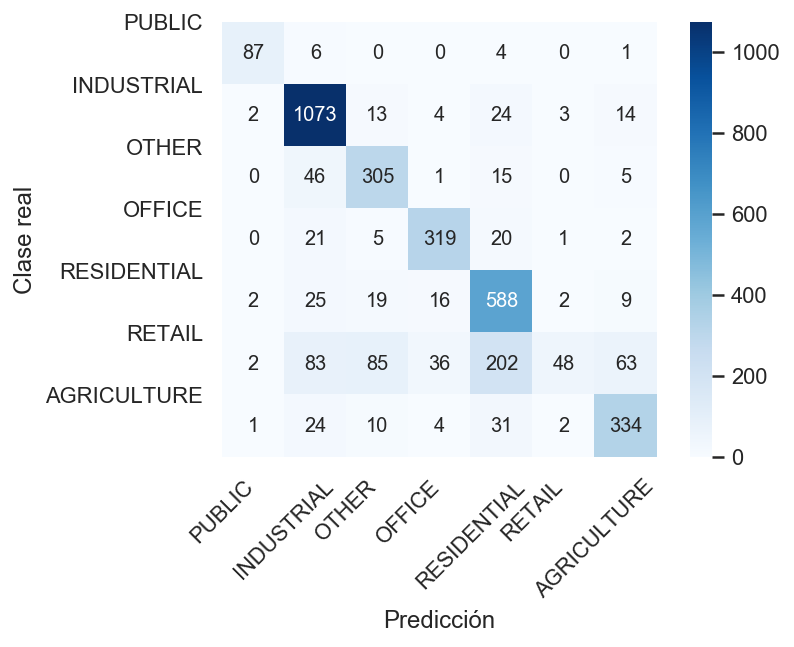

Resultados
Accuracy: 0.585


In [50]:
sns.heatmap(confusion_matrix(y_val, y_val_pred), square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
plt.ylabel('Clase real')
plt.xlabel('Predicción');
target_names = y_val.unique()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names, rotation=0)
plt.show()
print("Resultados")
print('Accuracy: {}'.format(round(accuracy_score(y_test, y_pred), 3)))

In [51]:
# Lo convertimos en serie para tener referenciado el ID
y_no_resident = pd.Series(index=X_val.index, data=y_val_pred)

In [52]:
all_data_pred = y_resident.append(y_no_resident)

In [53]:
accuracy_score(df_minsait['CLASE'], all_data_pred)

0.7624721495689237

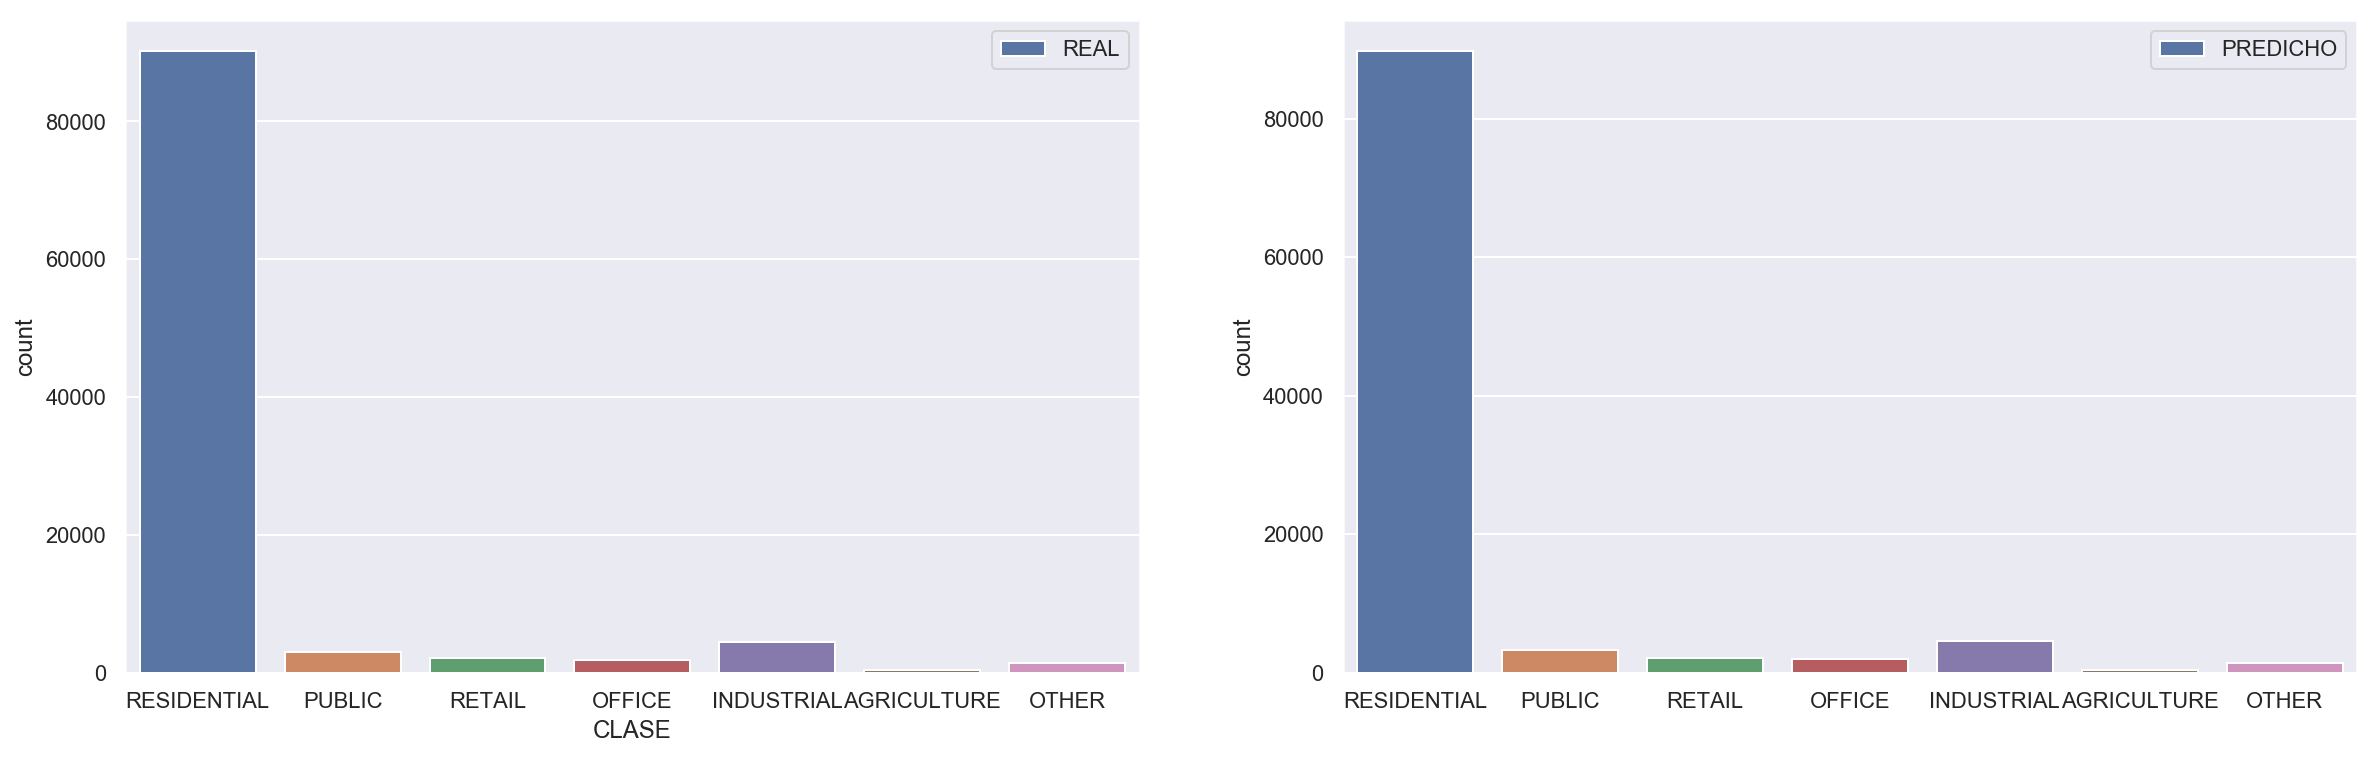

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
sns.countplot(df_minsait['CLASE'], order=list_class_order, ax=ax1, label='REAL');
sns.countplot(all_data_pred, order=list_class_order, ax=ax2, label='PREDICHO');
ax1.legend()
ax2.legend()

In [55]:
print('-----------------Valores reales---------------')
df_minsait['CLASE'].value_counts()

-----------------Valores reales---------------


RESIDENTIAL    90173
INDUSTRIAL      4490
PUBLIC          2976
RETAIL          2093
OFFICE          1828
OTHER           1332
AGRICULTURE      338
Name: CLASE, dtype: int64

In [56]:
print('-----------------Valores predichos---------------')
all_data_pred.value_counts()

-----------------Valores predichos---------------


RESIDENTIAL    89710
INDUSTRIAL      4635
PUBLIC          3199
RETAIL          2115
OFFICE          1893
OTHER           1344
AGRICULTURE      334
dtype: int64

Hay un problema con los count, ya que pueden no referenciar lo que sucede, por ejemplo un valro que es residencial y se equivoca entonces mejora alguna otra clase, pero realmente es un fallo, por eso sale un 0.76 y no más alto